In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import git
from git import Repo

from unidiff import PatchSet

import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib
import sys
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report

import copy


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import tree
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


from src import loading
from src import preprocessing
from src import visualization
from src import predictor

# TODO reorder this
from src.reorderer import *
from src.reordering_analyzer import ReorderingAnalyzer

# What data are we working with?

Our starting point is mutation testing data generated by [Mutester](https://github.com/XPerianer/CRM2020), a tool that was developed for exactly this task.
Also have a look at the [midterm presentation slides](../presentation/midterm.pdf) for more information about how and why we gathered data.

In [29]:
# It is possible to use the sparsify flag, if you want to test if models throw errors / for a quick check.
# USE WITH CAUTION: This is by no means designed to give an appropriate / random sample.
datasets = loading.load_datasets({
    'Flask': 'data/flask_full.pkl',
    #'Jinja': 'data/jinja_full.pkl',
    'Httpie': 'data/httpie_full.pkl',
    'Docopt': 'data/docopt_full.pkl'
}, sparsify=False)    

The main structure of such a datasets is that for each mutant, with it's respective `mutant_id`, and every test case, with it's respective `test_id`,
there is a row in the dataset, recording the outcome of the test, and additional information, like how long the test took, what files where touched, etc.

# Visualising Data generated by Mutation testing

In the beginning of the project, I tried to get a glimpse of the generated data by trying out different visualizations,
the most basic beeing the covariance matrix, and then two different approaches.

# Correlation Matrixes

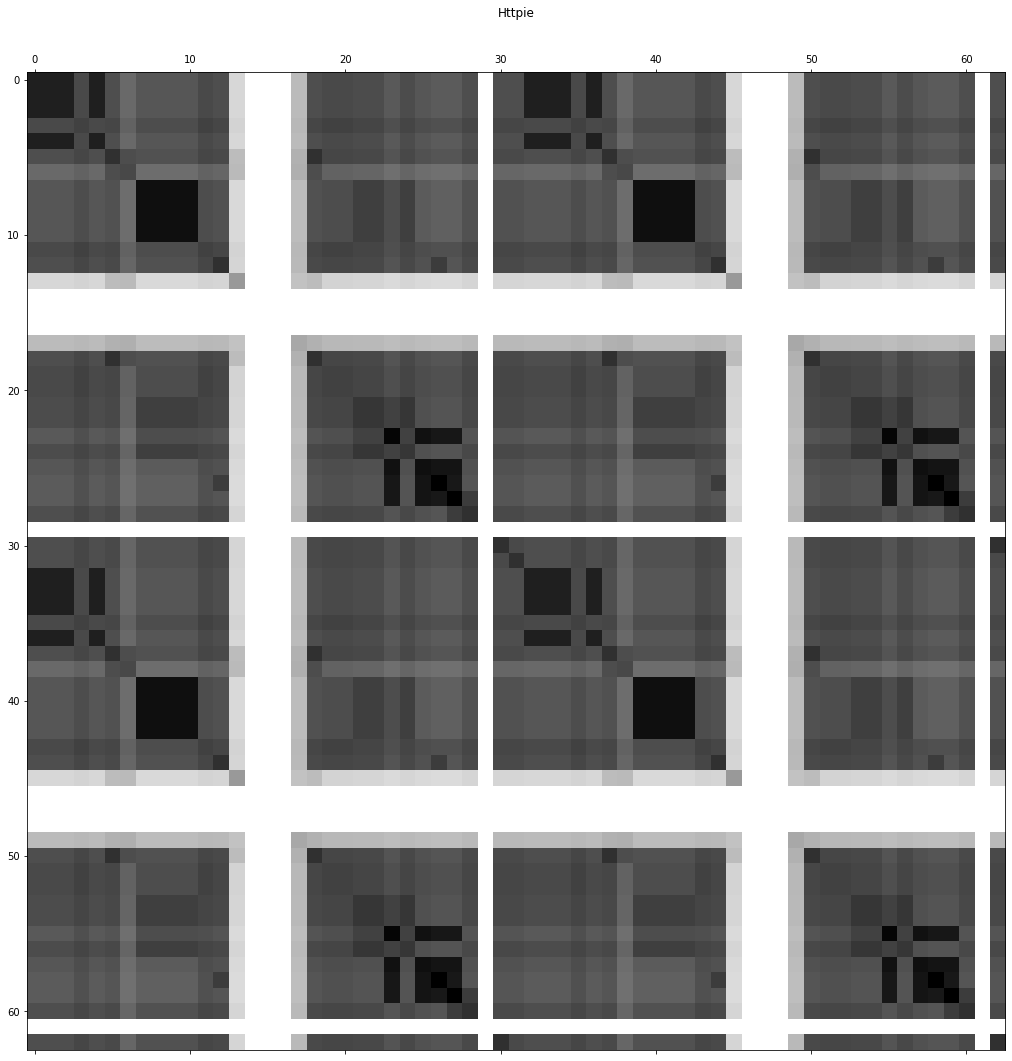

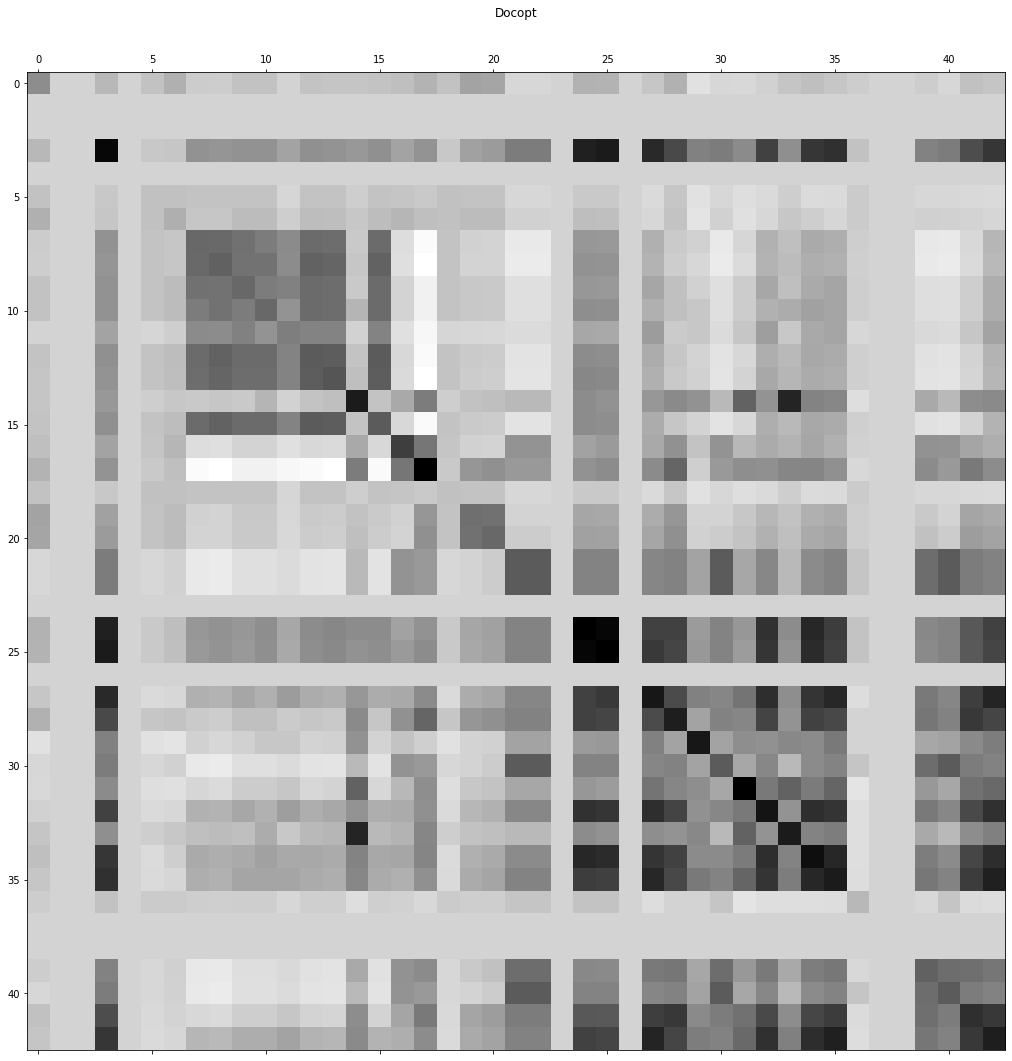

In [4]:
for name, mutants_and_tests in datasets.items():
    visualization.plot_covariance_matrix(name, mutants_and_tests)

An interesting aspect is also how often tests fail in general, and how the distribution is through the datasets:

What we can observe is that while flask and httpie have a very low number of often failing tests, jinja and docopt have a wider variety of tests failing.
We can see the behavoior also in the covariance matrixes, that are a lot lighter for flask and httpie, due to less covariance in tests often failing together.

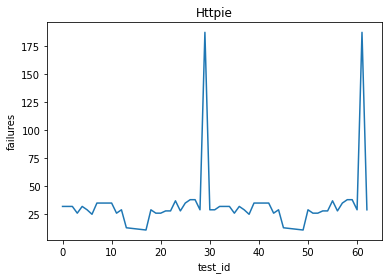

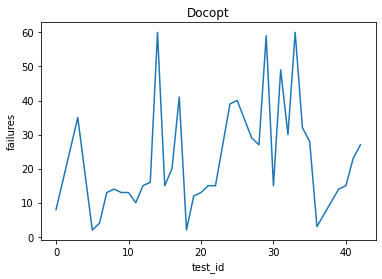

In [5]:
for name, data in datasets.items():
    visualization.plot_failure_histogram(name,data)

Later, it will also be interesting how the failure of the test correlates to the average duration of the test. You can see this in these scatter plots:


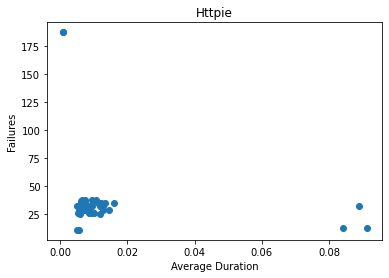

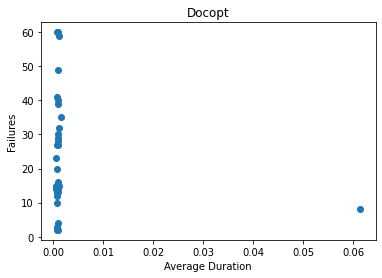

In [6]:
for name, data in datasets.items():
    visualization.plot_failures_vs_duration(name,data)

# Hierarchical Plot of tests


To try to get even more insight into the different datasets, I tried to come up with my own domain specific visualization, that builds on top of the failure histogram.

We print one dot for every test, with the following properties:
x axis = average of ids of changed line (mutant_ids) that make this test fail
y axis = number of mutants that make this test fail

So for example a unit test should be relatively wide down, since it should not fail on too many mutants.

To show the 'spread' of which mutant_ids made which tests fail, we draw an arrow from (mutant_id, 0) to (x,y) of the test, iff mutant_id makes the test fail

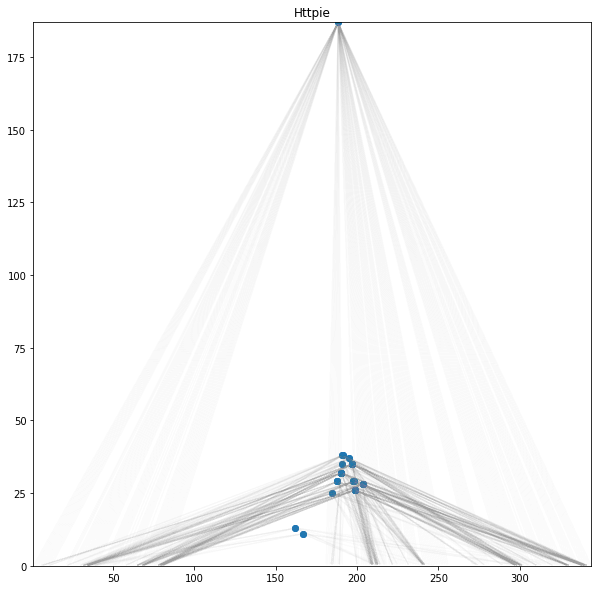

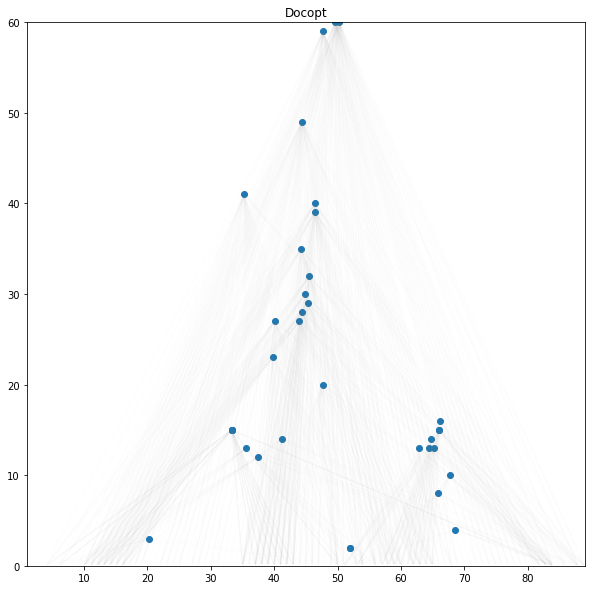

In [7]:
# For larger datasets, this may take a while (~5minutes). You can disable the arrows, then it becomes seconds
for name, mutants_and_tests in datasets.items():
    visualization.plot_hierarchical_failures(name, mutants_and_tests, arrows=True)

# Predicting failing tests

After having a fist visualization the data (and we will continue to do that), the question is if we can train machine learning models to predict failing tests.
While this has obious applications in test selection and reordering, we might also be able to find hidden dependecies in the dataset

# Data Preparation

### Cleansing and Feature Generation

In [30]:
encoded_column_names = ["modified_method", "modified_file_path", "name", "filepath", "current_line", "previous_line"]

encoded_datasets = {}
for name, mutants_and_tests in datasets.items():
    preprocessing.cleanse_data(mutants_and_tests)
    preprocessing.add_edit_distance_feature(mutants_and_tests)
    mutants_and_tests = preprocessing.filter_NaN_values(name, mutants_and_tests)
    encoded_datasets[name] = preprocessing.encode_columns(mutants_and_tests, encoded_column_names)


Flask: Kicked out 45 values from 958041 total values. (0.004697084989058187%) (NaN value filter)
Httpie: Kicked out 605 values from 322369 total values. (0.18767313234212546%) (NaN value filter)
Docopt: Kicked out 2 values from 95018 total values. (0.0021048643414900425%) (NaN value filter)


The method_name feature seems to make sense from a human perspective: If I change code in the same method, I would expect similar tests to fail.
But to go even further, I tried to add a numerical value, the edit distance between the test name and the method name. The expectation here was, that when both are similar, the test is more likely to fail. You can see examples for that in the presentation slides, page ... (TODO: LINK THAT)

In the ROC Curve, we can see that if we use the edit_distance as a standalone feature, Httpie and Flask behave better than Jinja and Docopt.
This is interesting, since we have previously seen that both of these projects also had a better distinsting between 'Unit Tests' that test a very specific part of the code, and very few integration tests.

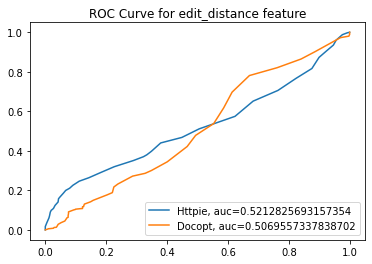

In [9]:
visualization.plot_edit_distance_roc_curve(datasets)

# Feature Selection

We can now select the features we want to use for our predictions.

To be on the save side, we previously drop
* features that could spoil y (`dangerous_features`)
* features that are unencoded (`unencoded_features`)

The features are grouped in three categories:
* Basic features, that are generated with the diff of the mutant, and also test properties
* Semantic features, which are generated from the semantics in the mutant
* Context features, which are gathered in the code around the test and the mutant
See also the [final_presentation_slides, page 37pp](../presentation/final.pdf)

In [31]:
dangerous_features = ['duration', 'setup_outcome', 'setup_duration', 'call_outcome', 'call_duration', 'teardown_outcome', 'teardown_duration']
unencoded_features = ['repo_path', 'full_name']

selected_features = [
    # Basic features:
    'current_line', 'line_number_changed',
    'modified_file_path', 'previous_line', 'test_id',
    'name', 'filepath', 'mutant_id', 'outcome',
    # Semantic features:
    'modified_method', 'edit_distance',
    # Context features:
    'contains_branch_mutant',
    'contains_equality_comparison_mutant', 'contains_loop_mutant',
    'contains_math_operands_mutant', 'contains_loop_execution', 'contains_math_operands_execution',
    'contains_equality_comparison_execution', 'contains_branch_execution'
]
    

for name, mutants_and_tests in encoded_datasets.items():
    encoded_datasets[name] = mutants_and_tests.drop(dangerous_features, axis=1).drop(unencoded_features, axis=1)[selected_features].copy()


In [32]:
test_train_data = {}

for name, mutants_and_tests in encoded_datasets.items():
    test_train_data[name] = preprocessing.train_test_split(mutants_and_tests)

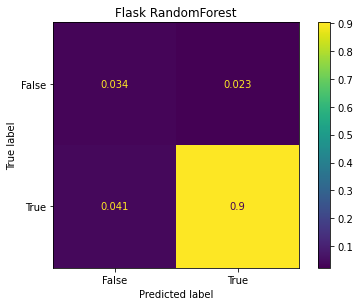

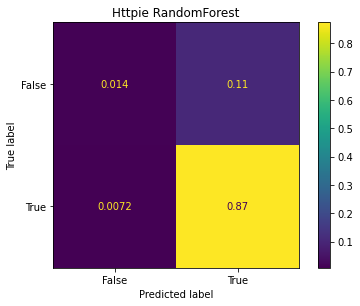

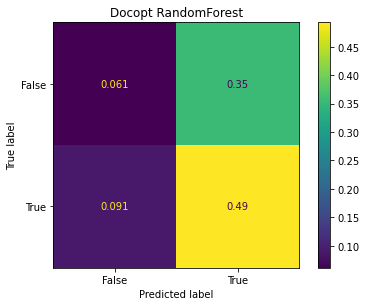

In [33]:
predictors = {
    #'NearestMutant': predictor.NearestMutantPredictor(),
    #'KNeighbors': KNeighborsClassifier(n_neighbors=1),
    'RandomForest': RandomForestClassifier(random_state=420),
}

fitted_predictors = {}

for dataset_name, mutants_and_tests in encoded_datasets.items():
    X_train, y_train, X_test, y_test = test_train_data[dataset_name]
    fitted_predictors[dataset_name] = {}
    for predictor_name, predictor_instance in predictors.items():
        predictor_instance = copy.deepcopy(predictor_instance)
        predictor_instance.fit(X_train, y_train)
        #print(predictor_instance.predict(X_test))
        visualization.plot_confusion_matrix(dataset_name + ' ' + predictor_name, predictor_instance, X_test, y_test)
        fitted_predictors[dataset_name][predictor_name] = predictor_instance
        

While we see that especially on the flask dataset the RandomForestClassifier performs better, this does not generalize to all datasets.
One nice thing about this classifier is that we can try to debug it using it's feature importances. These can give us a hint on what the forest uses to decide between a false and true outcome.

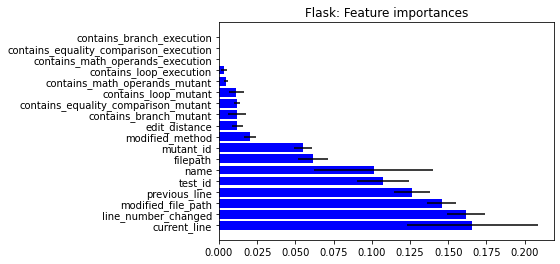

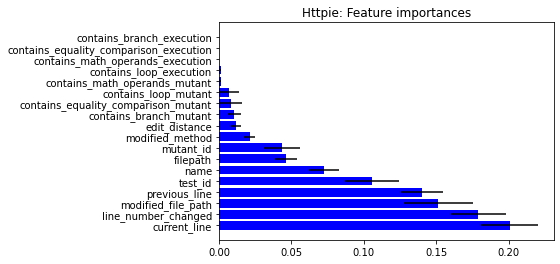

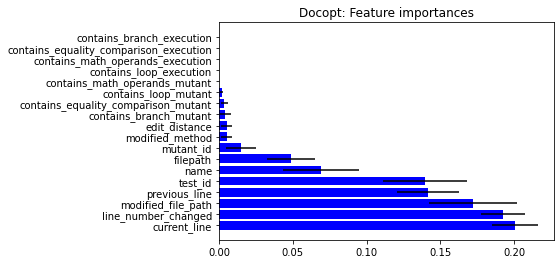

In [34]:
for name, fitted_predictor in fitted_predictors.items():
    visualization.plot_feature_importances(name, fitted_predictor['RandomForest'], test_train_data)

Here we can see that for the flask dataset, the random forest makes more usage of the 'semantic' features in the dataset, which might also be an indication that the tests in that project are especially well organized.
It would be an interesting point of research to check wether this can also be perceived by the human as a 'predictable' test suite.

# Test Case Reordering

While it is nice to be able to predict which test fail and which not, it is easier to decide if a classification is good or bad based on a concrete use case.
Therefore, the predictors are tested on various metrics in the test case reordering domain.
* APFD, which is a measure on how good a order of tests is in general, but which is duration agnostic
* APFDc, which is APFDc weighted after the average durations of the mentioned tests
* First Failing, which is the time that emerges till a test is found that fails
* Last Failing, which is the time that emerges till the last test that fails is found

There are multiple ways to derive an order for test case execution. To bridge the gap between prediction and reordering, there are 2 main helper classes:
* `BinaryPredictionReorderer`, which takes a binary predictor, and moves the (predicted) failing tests to the front
* `OrdinaryPredictionReorderer`, which sorts the tests ascending after there (predicted) chance of failing

To have some baseline, there are also some mutant agnostic Reorderes. That means that they will output the same order for every mutant:
* `NaiveReorderer`, which just outputs the tests after ascending test_ids
* `AverageReorderer`, which orders the tests after there overall a priori probability to fail
* `QTF`, which is sorting the tests ascending after there duration. It is a heuristic mentioned in [this paper](https://dl.acm.org/doi/pdf/10.1145/3395363.3397383)

The `ReorderingAnalyzer` class can be used to automatically train and evaluate the reorderes, and print boxplots:

Starting evaluation .. finished.
Starting evaluation .. finished.
Starting evaluation .. finished.
Starting evaluation .. finished.
Starting evaluation .. finished.
Starting evaluation .. finished.
Starting evaluation .. finished.
Starting evaluation .. finished.
Starting evaluation .. finished.
Dataset: Httpie


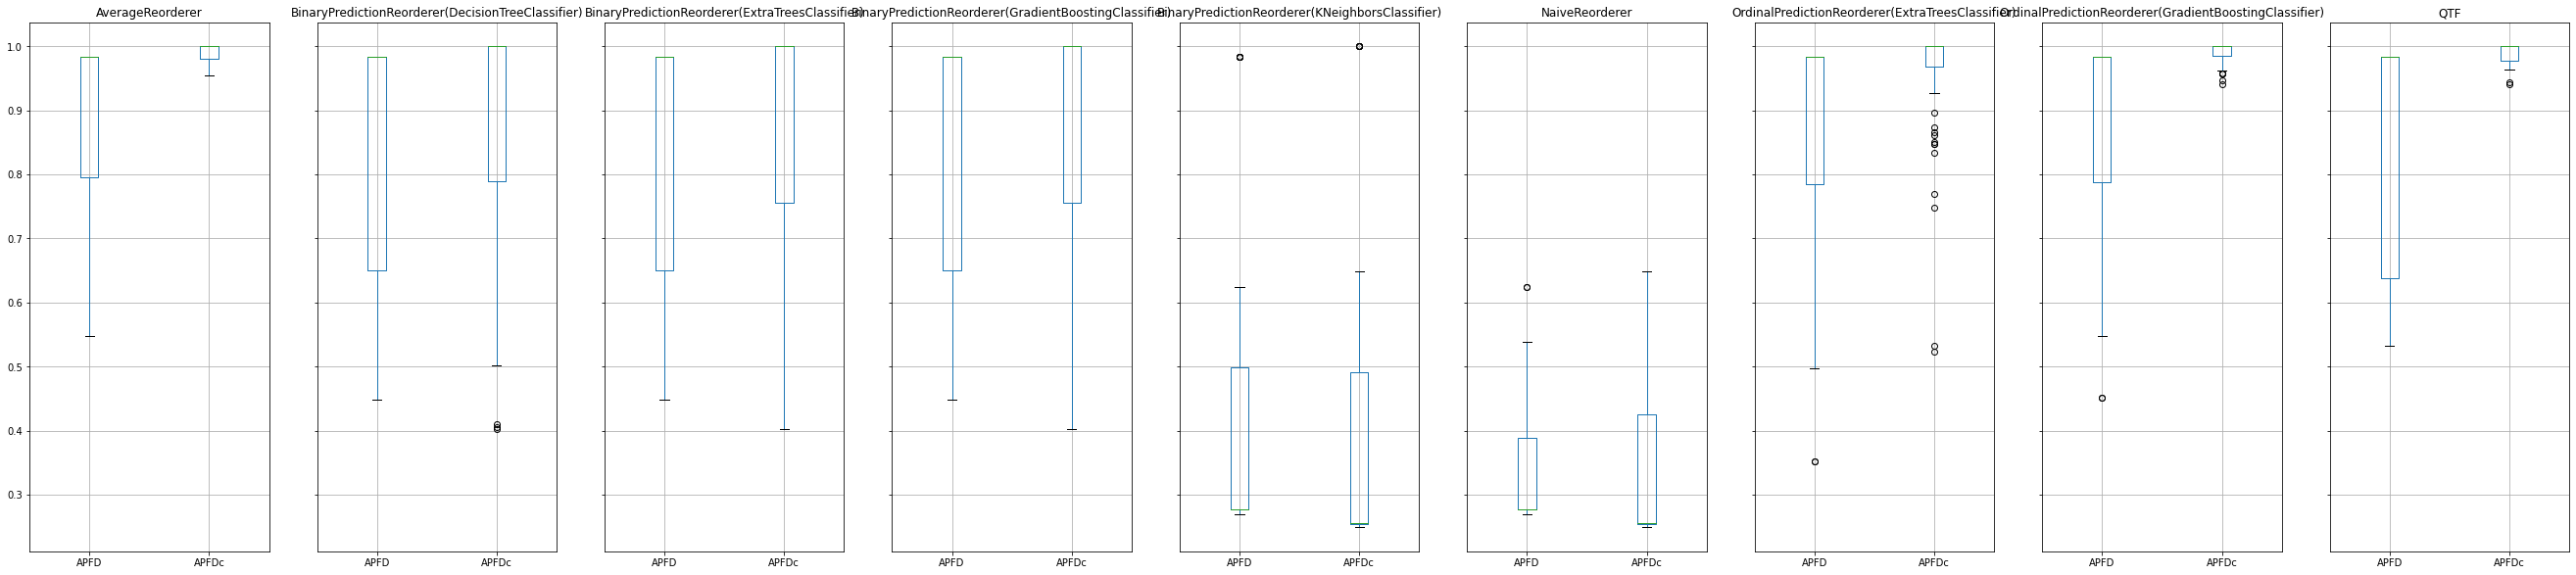

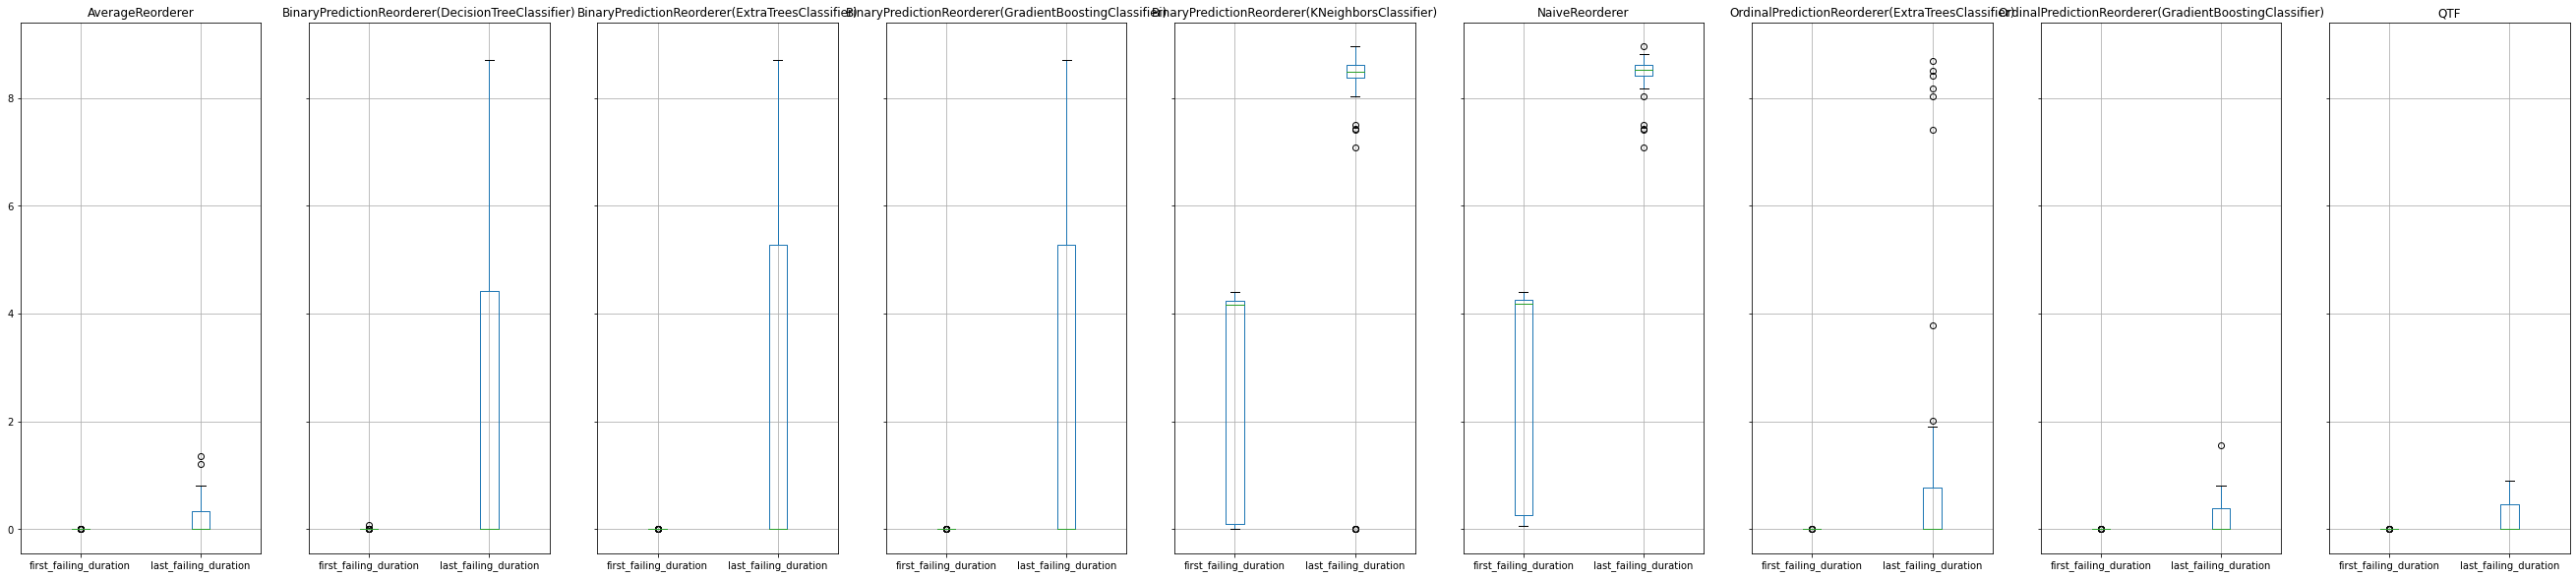

Starting evaluation  finished.
Starting evaluation  finished.
Starting evaluation  finished.
Starting evaluation  finished.
Starting evaluation  finished.
Starting evaluation  finished.
Starting evaluation  finished.
Starting evaluation  finished.
Starting evaluation  finished.
Dataset: Docopt


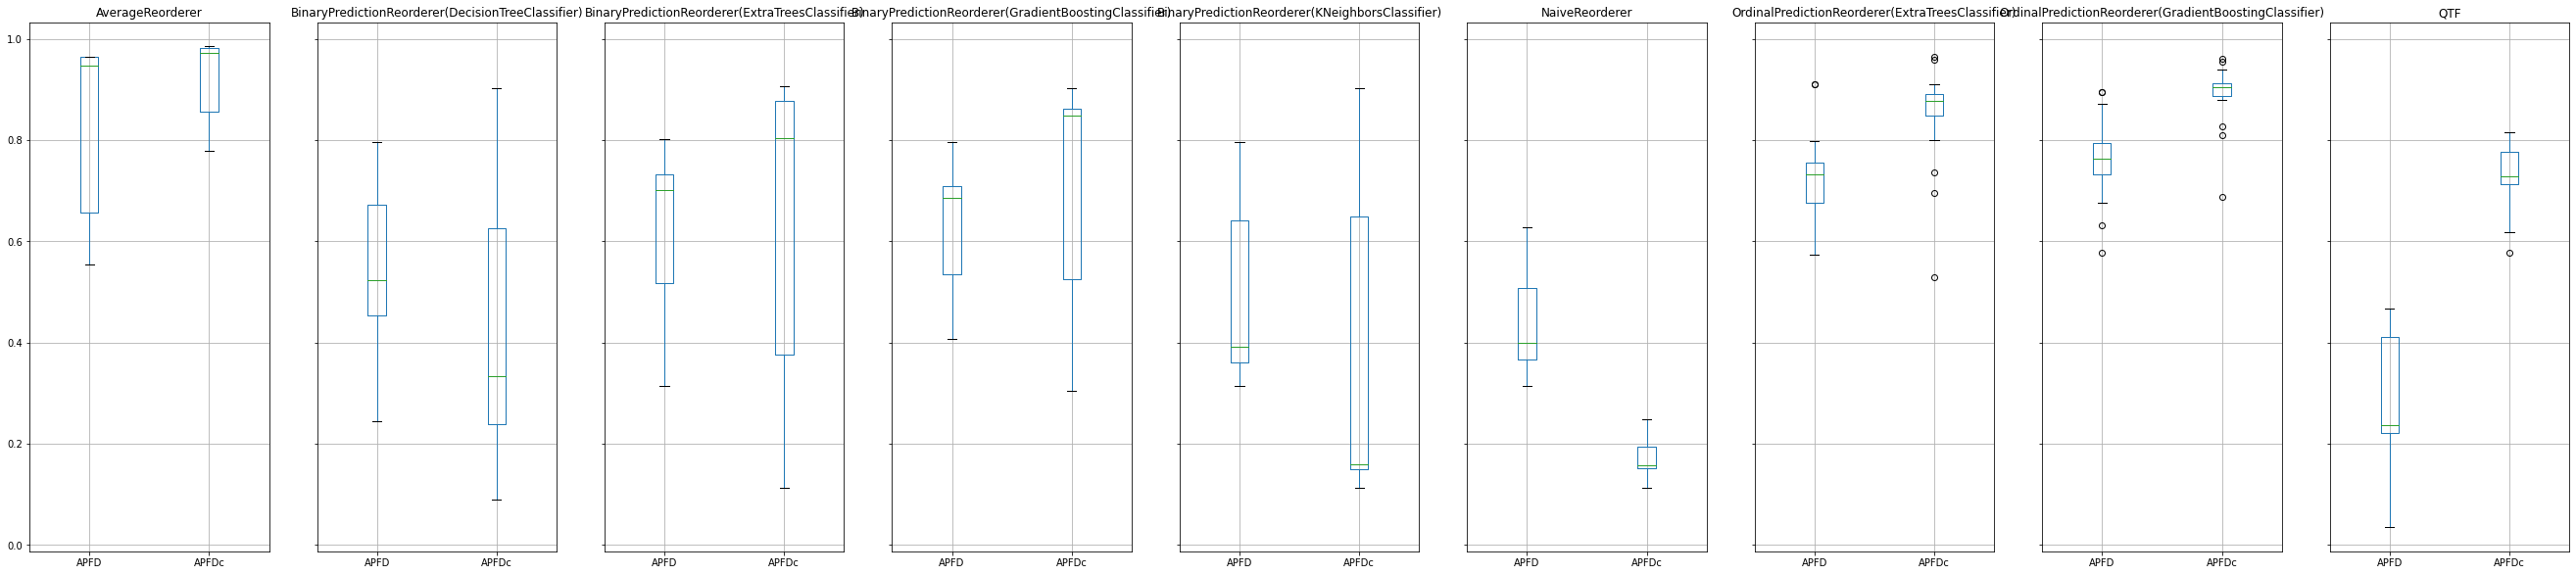

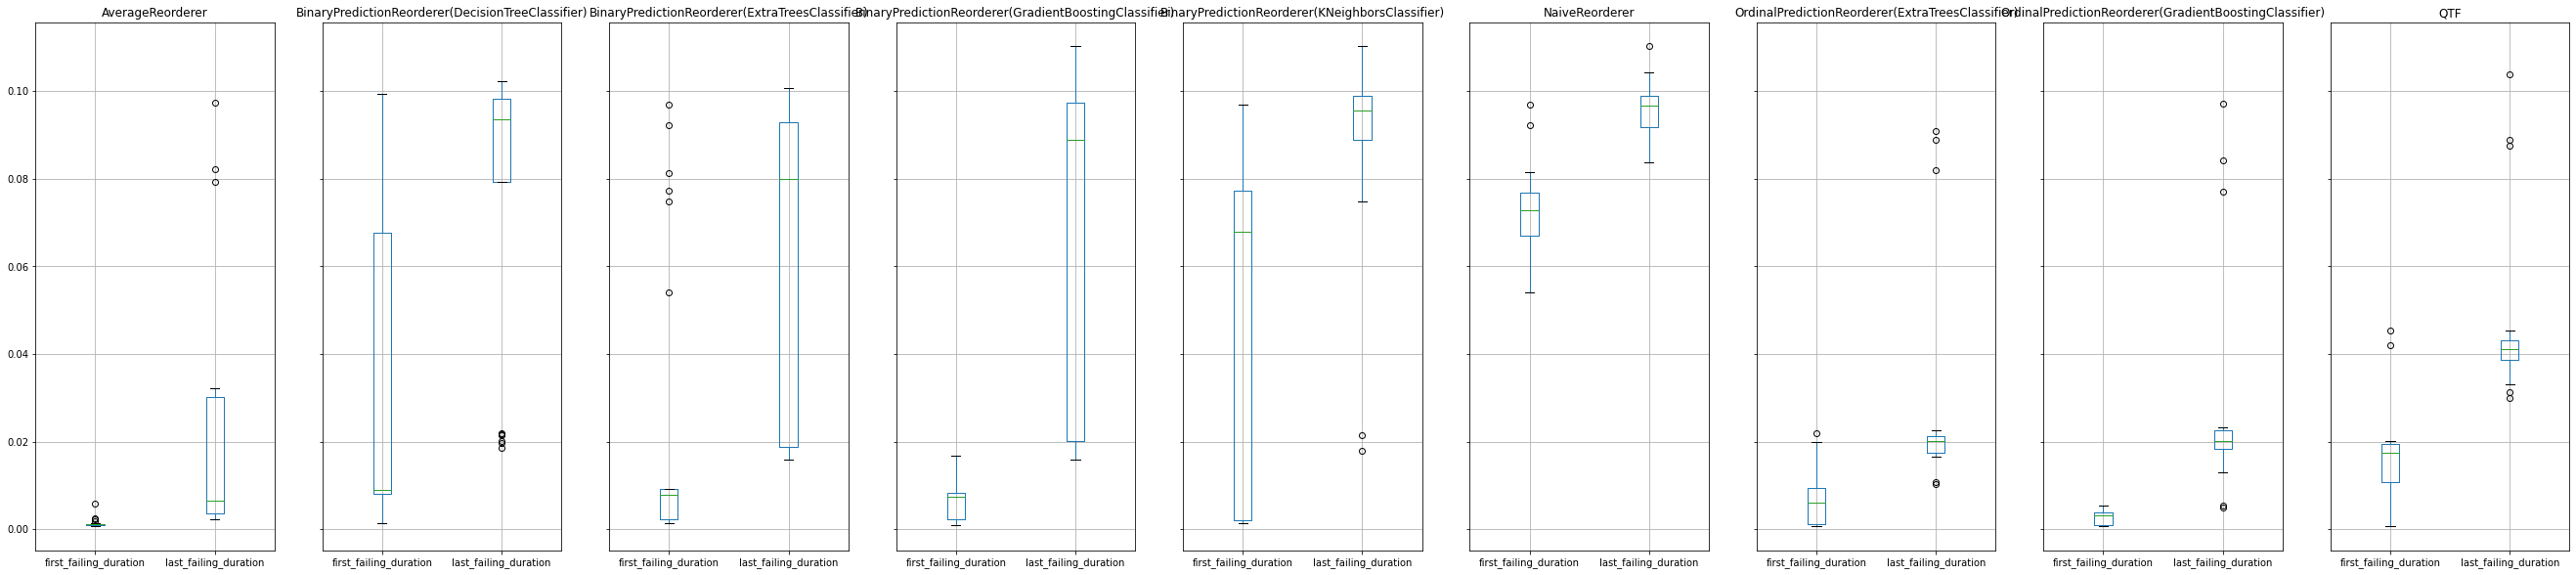

In [14]:
for name, mutants_and_tests in encoded_datasets.items():
    evaluation = ReorderingAnalyzer([
        NaiveReorderer(),
        AverageReorderer(),
        QTF(datasets[name][['test_id', 'duration']]),
        BinaryPredictionReorderer(tree.DecisionTreeClassifier(ccp_alpha=0.001)),
        BinaryPredictionReorderer(KNeighborsClassifier()),
        BinaryPredictionReorderer(ExtraTreesClassifier(random_state=420)),
        OrdinalPredictionReorderer(ExtraTreesClassifier(random_state=420)),
        BinaryPredictionReorderer(GradientBoostingClassifier(random_state=420)),
        OrdinalPredictionReorderer(GradientBoostingClassifier(random_state=420))
    ])
    X_train, y_train, X_test, y_test = preprocessing.train_test_split(mutants_and_tests)
    evaluation.fit(X_train, y_train)
    evaluation.predict(X_test)
    evaluation_data = evaluation.evaluate(datasets[name])
    print('Dataset: ' + name)
    evaluation.boxplot()
    plt.show()